### Import libraries

In [303]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , RobustScaler
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

sns.set_palette(sns.color_palette("viridis"))

### Loading data

#### We are not going to use test.csv data, because it consists of train.csv data, and this can lead to data leak

In [304]:
train_df = pd.read_csv('/kaggle/input/banking-dataset-marketing-targets/train.csv', sep=';')
print(f"Dataset shape - {train_df.shape}")
train_df.head()

Dataset shape - (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [305]:
test_df = pd.read_csv('/kaggle/input/banking-dataset-marketing-targets/test.csv', sep=';')
print(f"Dataset shape - {test_df.shape}")
test_df = test_df.rename(columns={'y': 'target'})
test_df.head()

Dataset shape - (4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [306]:
train_df = train_df.rename(columns={'y': 'target'})
train_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [307]:
result = pd.concat([train_df, test_df])
result.reset_index(inplace=True)

## Prepare data for visualizing'

Copy training dataframe for manipulations during EDA

In [308]:
df = result.copy()
df

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
49728,4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
49729,4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
49730,4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49732 entries, 0 to 49731
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      49732 non-null  int64 
 1   age        49732 non-null  int64 
 2   job        49732 non-null  object
 3   marital    49732 non-null  object
 4   education  49732 non-null  object
 5   default    49732 non-null  object
 6   balance    49732 non-null  int64 
 7   housing    49732 non-null  object
 8   loan       49732 non-null  object
 9   contact    49732 non-null  object
 10  day        49732 non-null  int64 
 11  month      49732 non-null  object
 12  duration   49732 non-null  int64 
 13  campaign   49732 non-null  int64 
 14  pdays      49732 non-null  int64 
 15  previous   49732 non-null  int64 
 16  poutcome   49732 non-null  object
 17  target     49732 non-null  object
dtypes: int64(8), object(10)
memory usage: 6.8+ MB


In [310]:
df.isna().sum()

index        0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
dtype: int64

In [311]:
df.describe()

,index,age,balance,day,duration,campaign,pdays,previous
count,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000
mean,20755.491736,40.957472,1367.761562,15.816315,258.690179,2.766549,40.158630,0.576892
std,13755.639646,10.615008,3041.608766,8.315680,257.743149,3.099075,100.127123,2.254838
min,0.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,7911.750000,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,20344.500000,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,32777.250000,48.000000,1431.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,45210.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


#### Transform binary category features to int

In [312]:
binary_columns = []
for column in df.select_dtypes('object').columns:
    if len(df[column].unique()) == 2:
        binary_columns.append(column)
    print(f"Column - {column} ",df[column].unique(), end='\n\n')
    
    

Column - job  ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

Column - marital  ['married' 'single' 'divorced']

Column - education  ['tertiary' 'secondary' 'unknown' 'primary']

Column - default  ['no' 'yes']

Column - housing  ['yes' 'no']

Column - loan  ['no' 'yes']

Column - contact  ['unknown' 'cellular' 'telephone']

Column - month  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Column - poutcome  ['unknown' 'failure' 'other' 'success']

Column - target  ['no' 'yes']



##  EDA

### Target feature

Target variable is highly imbalanced, this will impact perfomance of a model, this can be fixed with SMOTE technique

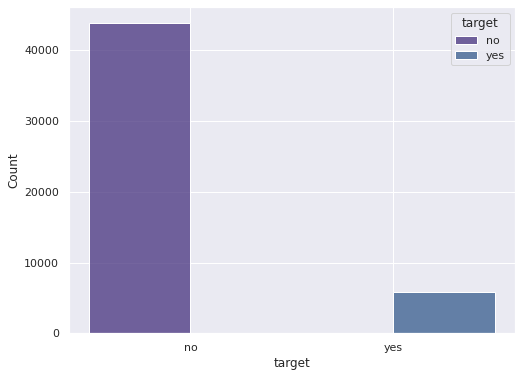

In [313]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x="target", hue="target", multiple="dodge",binwidth=1.3)
plt.show()

### Education

Most clients have secondary education

Let's see how education impacts our target variable

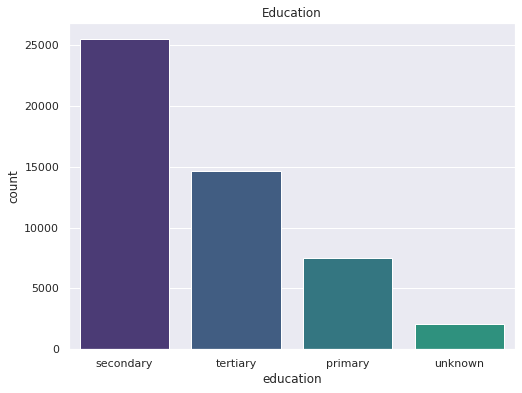

In [314]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'education',
              data = df,
              order = df['education'].value_counts().index)
plt.title('Education')
plt.show()

Even if we have more clients that have secondary education, by average clients who have tertiary have a positive target value.

So, in theory this can impact output of the model

In [315]:
education_target = df.groupby('education', as_index=False)['target']
# education_target_mean = education_target.mean().sort_values(by='target', ascending=False)
education_target_sum = education_target.sum().sort_values(by='target', ascending=False)

In [316]:
# plt.figure(figsize=(16,10))
# plt.subplot(1,3,1)
# sns.histplot(data=df, x="education", hue="target", multiple="dodge",binwidth=1.1,shrink=.8)
# plt.title('Distribution of target value by education')

# plt.subplot(1,3,2)
# sns.barplot(data=education_target_mean, x='education', y='target')
# plt.xlabel("education")
# plt.ylabel("Mean target")
# plt.title("Mean target value by education")

# plt.subplot(1,3,3)
# sns.barplot(data=education_target_sum, x='education', y='target')
# plt.xlabel("Education")
# plt.ylabel("Sum target")
# plt.title("Sum target value by education")

# plt.show()

Also, clients who have secondary education and loan in average subscribe a term deposit more

This can also impact the results of model

In [317]:
# education_group = df.groupby('education', as_index=False)
# education_loan_mean = education_group['loan'].mean().sort_values(by='loan', ascending=False)
# education_loan_sum = education_group['loan'].sum().sort_values(by='loan', ascending=False)

# education_default_mean = education_group['default'].mean().sort_values(by='default', ascending=False)
# education_default_sum = education_group['default'].sum().sort_values(by='default', ascending=False)

# education_loan_mean

In [318]:
# plt.figure(figsize=(16,12))
# plt.subplot(3,2,1)

# sns.histplot(data=df, x="education", hue="loan", multiple="dodge",binwidth=1.1,shrink=.8)
# plt.title('Distribution of loan by education')

# plt.subplot(3,2,2)
# sns.histplot(data=df, x="education", hue="default", multiple="dodge",binwidth=1.1,shrink=.8)
# plt.title('Distribution of default by education')

# plt.subplot(3,2,3)
# sns.barplot(data=education_loan_mean, x='education', y='loan',)
# plt.xlabel("education")
# plt.ylabel("Mean loan")
# plt.title("Mean loan by education")

# plt.subplot(3,2,4)
# sns.barplot(data=education_loan_sum, x='education', y='loan')
# plt.xlabel("education")
# plt.ylabel("Sum loan")
# plt.title("Sum loan by education")

# plt.subplot(3,2,5)
# sns.barplot(data=education_default_mean, x='education', y='default')
# plt.xlabel("education")
# plt.ylabel("Mean default")
# plt.title("Mean default by education")

# plt.subplot(3,2,6)
# sns.barplot(data=education_default_sum, x='education', y='default')
# plt.xlabel("education")
# plt.ylabel("Sum default")
# plt.title("Sum default by education")
# plt.tight_layout()
# plt.show()

### Job

Most of the cliens have blue-collar, management or technician job

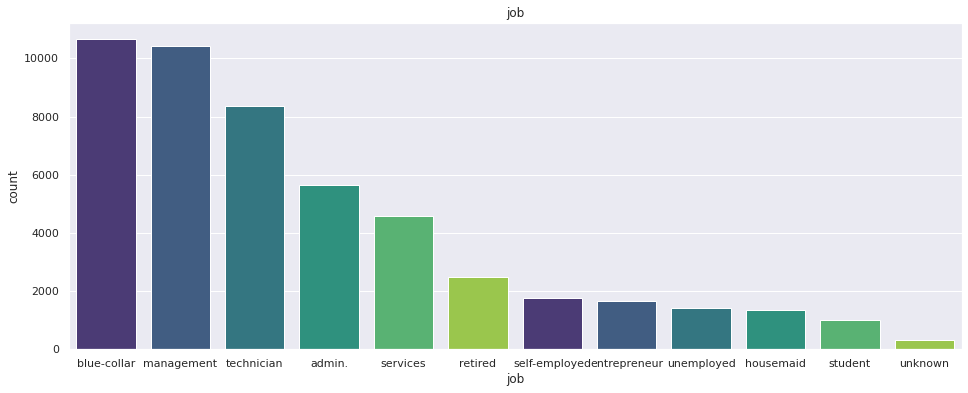

In [319]:
plt.figure(figsize=(16,6))
sns.countplot(x = 'job',
              data = df,
              order = df['job'].value_counts().index, palette=sns.color_palette('viridis'))
plt.title('job')
plt.show()

But, as we can see, in average students and retired clients subscribed for deposit more

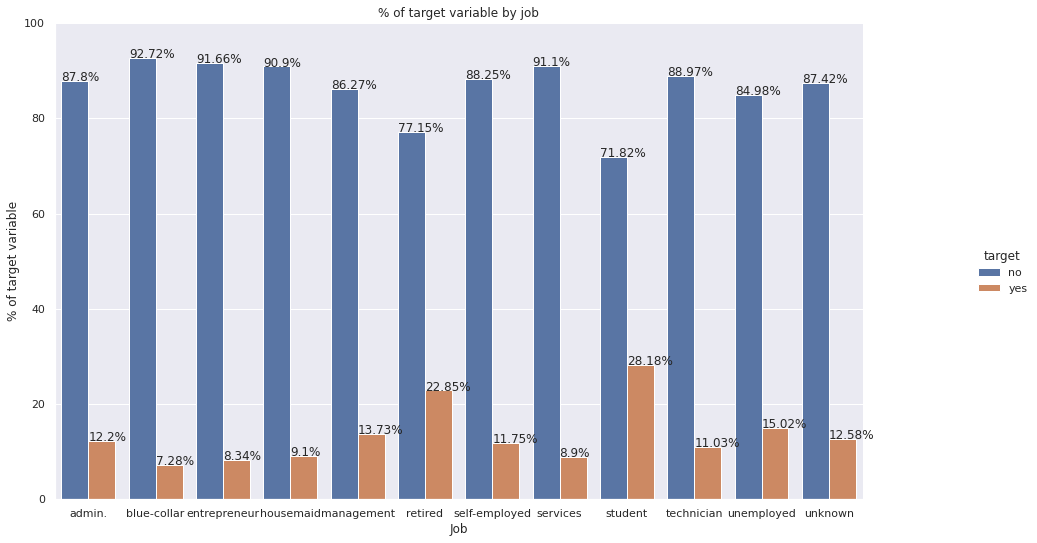

In [320]:
sns.set(rc={'figure.figsize':(16,18)})
x,y = 'job', 'target'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g= sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.figure.set_figheight(8)
g.figure.set_figwidth(16)
g.ax.set_ylim(0,100)
g.ax.set_xlabel('Job')
g.ax.set_ylabel('% of target variable')
g.ax.set_title("% of target variable by job")
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)




We have no high correlation between features

### preprocessing

In [321]:
for column in binary_columns:
    df[column] = df[column].map({'yes': 1, 'no': 0})
    
#df.loc[:, binary_columns]

In [322]:
features_numeric=list(df.select_dtypes(include=['float64', 'int64']))
features_numeric = df[features_numeric]
features_numeric

,index,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,target
0,0,58,0,2143,1,0,5,261,1,-1,0,0
1,1,44,0,29,1,0,5,151,1,-1,0,0
2,2,33,0,2,1,1,5,76,1,-1,0,0
3,3,47,0,1506,1,0,5,92,1,-1,0,0
4,4,33,0,1,0,0,5,198,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49727,4516,33,0,-333,1,0,30,329,5,-1,0,0
49728,4517,57,1,-3313,1,1,9,153,1,-1,0,0
49729,4518,57,0,295,0,0,19,151,11,-1,0,0
49730,4519,28,0,1137,0,0,6,129,4,211,3,0


In [323]:
# df['pdays'] = df['pdays'].astype("str").replace('-1' , '0')
# df['pdays'] = df['pdays'].astype("int64")
df.drop(['index', 'pdays'] , axis = 1 , inplace=True)

In [324]:
for col in df[list(df.select_dtypes(include=['float64', 'int64']))].columns : 
    print(f'for feature {col}')
    print(f'Number of Nulls is {df[col].isna().sum()}')
    print(f'Number of Unique Values {len(df[col].unique())}')
    print(f'First values of Unique {df[col].unique()[:]}')
    print('----------------------------------')

for feature age
Number of Nulls is 0
Number of Unique Values 77
First values of Unique [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
----------------------------------
for feature default
Number of Nulls is 0
Number of Unique Values 2
First values of Unique [0 1]
----------------------------------
for feature balance
Number of Nulls is 0
Number of Unique Values 7168
First values of Unique [ 2143    29     2 ...  8205 14204 16353]
----------------------------------
for feature housing
Number of Nulls is 0
Number of Unique Values 2
First values of Unique [1 0]
----------------------------------
for feature loan
Number of Nulls is 0
Number of Unique Values 2
First values of Unique [0 1]
----------------------------------
for feature day
Number of Nulls is 0
Number of Unique Values 31
First values of Un

In [325]:
df[df['balance'] == 0 ]['target'].value_counts()

0    3550
1     321
Name: target, dtype: int64

In [326]:
df[df['balance'] < 0 ]['target'].value_counts()

0    3891
1     241
Name: target, dtype: int64

In [327]:
df['target'].value_counts()

0    43922
1     5810
Name: target, dtype: int64

<AxesSubplot:xlabel='balance', ylabel='Density'>

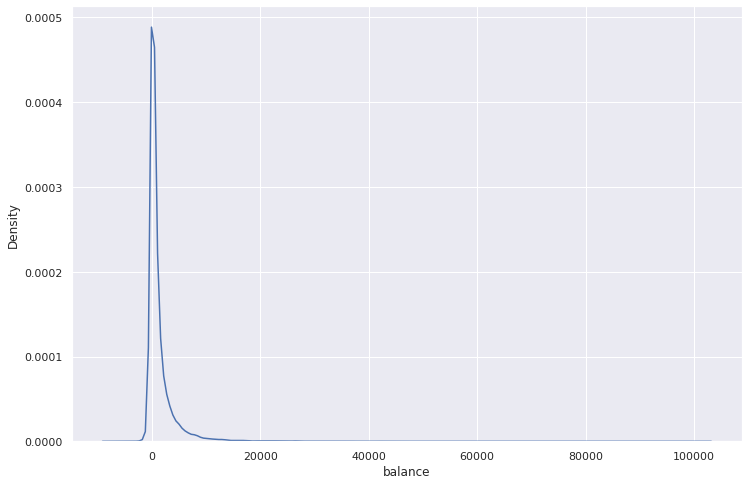

In [328]:
sns.set(rc={'figure.figsize':(12,8)})
sns.kdeplot(data = df , x ="balance")

<AxesSubplot:xlabel='balance'>

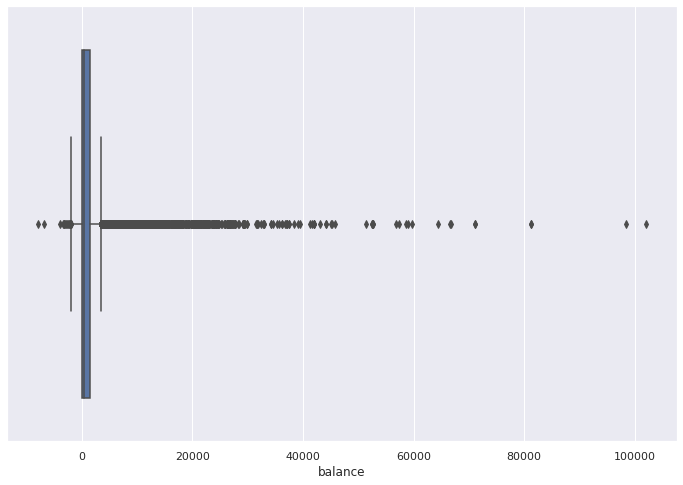

In [329]:
sns.boxplot(data = df  , x ="balance")

### preprocessing categorical

In [330]:
df[df['job']=='unknown']['education'].value_counts()

unknown      142
secondary     79
primary       58
tertiary      47
Name: education, dtype: int64

In [331]:
indexNeg = df[(df['job']=='unknown') & (df['education']=='unknown')].index # Creating the set of rows to be dropped

df.drop(indexNeg, inplace=True) # Droping the rows

In [332]:
# Finding the mode's

print('Primary education JOB mode is:', df[df['education']=='primary']['job'].value_counts(normalize=True).nlargest(3))

print('Secondary education JOB mode is', df[df['education']=='secondary']['job'].value_counts(normalize=True).nlargest(3))

print('Tertiary education JOB mode is', df[df['education']=='tertiary']['job'].value_counts(normalize=True).nlargest(3))

Primary education JOB mode is: blue-collar    0.548147
retired        0.116217
housemaid      0.090849
Name: job, dtype: float64
Secondary education JOB mode is blue-collar    0.231104
technician     0.225380
admin.         0.180806
Name: job, dtype: float64
Tertiary education JOB mode is management       0.586172
technician       0.148727
self-employed    0.062863
Name: job, dtype: float64


In [333]:
df['job'] = np.where( ((df.job == 'unknown')& (df.education =='primary')),'blue-collar',df.job)


df['job'] = np.where( ((df.job == 'unknown')& (df.education =='tertiary')),'management',df.job)

import random

secjobs=['blue-collar','technician','admin.']
i=0
while i <74:
    p=random.choice(secjobs)
    df['job'] = np.where( ((df.job == 'unknown')&(df.education =='secondary')),p,df.job)
    i=i+1

In [334]:
df[df['education']=='unknown']['job'].value_counts()

blue-collar      495
management       269
technician       264
admin.           188
student          179
services         163
retired          133
entrepreneur      87
housemaid         50
self-employed     43
unemployed        31
Name: job, dtype: int64

In [335]:
# Finding the mode's

print('JOB Blue-Collar education mode is:', df[df['job']=='blue-collar']['education'].value_counts(normalize=True).nlargest(2))

print('JOB technician education mode is:', df[df['job']=='technician']['education'].value_counts(normalize=True).nlargest(2))

print('JOB management education mode is:', df[df['job']=='management']['education'].value_counts(normalize=True).nlargest(2))

print('JOB admin education mode is:', df[df['job']=='admin.']['education'].value_counts(normalize=True).nlargest(2))

print('JOB student education mode is:', df[df['job']=='student']['education'].value_counts(normalize=True).nlargest(2))

print('JOB services education mode is:', df[df['job']=='services']['education'].value_counts(normalize=True).nlargest(2))

print('JOB retired education mode is:', df[df['job']=='retired']['education'].value_counts(normalize=True).nlargest(2))

print('JOB entrepreneur education mode is:', df[df['job']=='entrepreneur']['education'].value_counts(normalize=True).nlargest(2))

print('JOB housemaid education mode is:', df[df['job']=='housemaid']['education'].value_counts(normalize=True).nlargest(2))

print('JOB self-employed education mode is:', df[df['job']=='self-employed']['education'].value_counts(normalize=True).nlargest(2))

print('JOB unemployed education mode is:', df[df['job']=='unemployed']['education'].value_counts(normalize=True).nlargest(2))

JOB Blue-Collar education mode is: secondary    0.552381
primary      0.386963
Name: education, dtype: float64
JOB technician education mode is: secondary    0.687268
tertiary     0.260490
Name: education, dtype: float64
JOB management education mode is: tertiary     0.824422
secondary    0.118102
Name: education, dtype: float64
JOB admin education mode is: secondary    0.816428
tertiary     0.110285
Name: education, dtype: float64
JOB student education mode is: secondary    0.543053
tertiary     0.236791
Name: education, dtype: float64
JOB services education mode is: secondary    0.835703
primary      0.080945
Name: education, dtype: float64
JOB retired education mode is: secondary    0.436648
primary      0.350842
Name: education, dtype: float64
JOB entrepreneur education mode is: tertiary     0.458610
secondary    0.362538
Name: education, dtype: float64
JOB housemaid education mode is: primary      0.505917
secondary    0.312870
Name: education, dtype: float64
JOB self-employed edu

In [336]:
s=['blue-collar', 'technician', 'admin.' ,'student', 'education', 'retired', 'services' ,'unemployed']
t=['management','entrepreneur','self-employed']

# TRAIN DATA

for job in s:
    df['education'] = np.where( ((df.education == 'unknown')& (df.job ==job)),'secondary',df.education)
    
for job in t:
    df['education'] = np.where( ((df.education == 'unknown')& (df.job ==job)),'tertiary',df.education)
    
df['education'] = np.where( ((df.education == 'unknown')& (df.job =='housemaid')),'primary',df.education)

In [337]:
df['contact'] = np.where( (df.contact == 'unknown'),'cellular',df.contact)

In [338]:
df['contact'].value_counts()

cellular     46410
telephone     3180
Name: contact, dtype: int64

In [339]:
round(df['poutcome'].value_counts(normalize=True)*100,2)

unknown    81.74
failure    10.86
other       4.11
success     3.30
Name: poutcome, dtype: float64

In [340]:
df.drop(columns=['poutcome'],inplace=True)

In [341]:
# df.drop(columns=['day'],inplace=True)
# df.drop(columns=['pdays'],inplace=True)

In [342]:
month_dict = {'may':5, 
        'jun':6, 
        'jul':7, 
        'aug':8, 
        'oct':10, 
        'nov':11,
        'dec':12,
        'jan':1,
        'feb':2,
        'mar': 3,
        'apr': 4,
        'sep':9 }

education_dict = {"secondary" : 2 , 'tertiary' : 3 , "primary"  : 1 }

# apply using map
df['month'] = df['month'].map(month_dict)
df['education'] = df['education'].map(education_dict)

In [343]:
print(sdjfl)

NameError: name 'sdjfl' is not defined

In [358]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,target
0,58,management,married,3,0,2143,1,0,cellular,5,5,261,1,0,0
1,44,technician,single,2,0,29,1,0,cellular,5,5,151,1,0,0
2,33,entrepreneur,married,2,0,2,1,1,cellular,5,5,76,1,0,0
3,47,blue-collar,married,2,0,1506,1,0,cellular,5,5,92,1,0,0
5,35,management,married,3,0,231,1,0,cellular,5,5,139,1,0,0


In [388]:
label_df = df.copy()

In [389]:
# label_df['balance'] = label_df['balance'].apply(lambda x : 0 if x < 0 else x )
# label_df['duration'] = label_df['duration'] / 60 
# cols = ["balance",'duration']
# for col in cols :
#     label_df[col] = np.log(label_df[col])

# label_df.head()    

In [418]:
# label_df.isna().sum()

In [420]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,target
0,58,management,married,3,0,2143,1,0,cellular,5,5,261,1,0,0
1,44,technician,single,2,0,29,1,0,cellular,5,5,151,1,0,0
2,33,entrepreneur,married,2,0,2,1,1,cellular,5,5,76,1,0,0
3,47,blue-collar,married,2,0,1506,1,0,cellular,5,5,92,1,0,0
5,35,management,married,3,0,231,1,0,cellular,5,5,139,1,0,0


In [421]:
label_df['duration'] = label_df['duration'] / 60 

<AxesSubplot:>

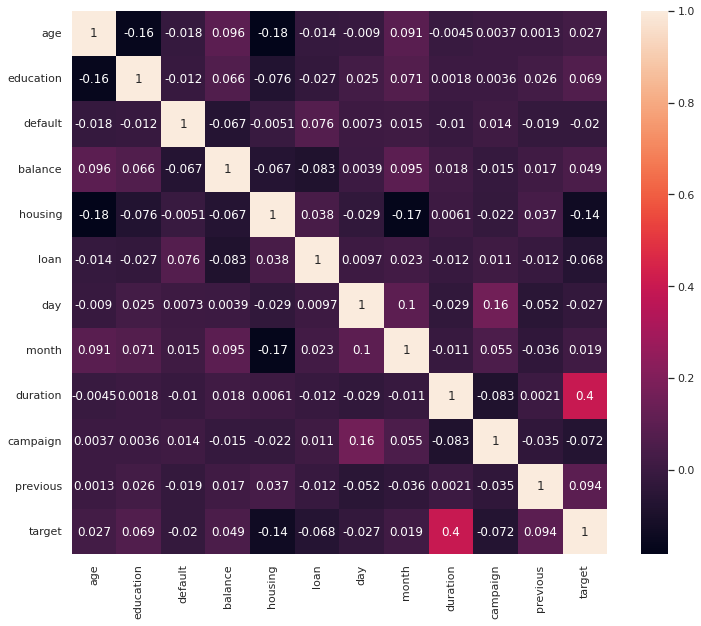

In [422]:
plt.figure(figsize=(12,10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot =True)

In [423]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['job'], df['education'])

# perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# print the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 30830.190891760576
P-value: 0.0
Degrees of freedom: 20
Expected frequencies:
[[ 863.35493043 3071.23793103 1714.40713854]
 [1652.89140956 5879.87931034 3282.2292801 ]
 [ 252.9389998   899.78735632  502.27364388]
 [ 206.63053035  735.05287356  410.31659609]
 [1600.77527727 5694.48505747 3178.73966526]
 [ 381.16608187 1355.93333333  756.9005848 ]
 [ 269.29215568  957.96091954  534.74692478]
 [ 698.60070579 2485.15287356 1387.24642065]
 [ 156.19556362  555.63908046  310.16535592]
 [1278.44998992 4547.86781609 2538.68219399]
 [ 218.70435572  778.00344828  434.29219601]]


In [424]:
Encoder = ColumnTransformer(transformers=[("OHE" , OneHotEncoder(sparse=False , drop="first") , ["marital" , "contact" , "job" ]  )  ] ,remainder="passthrough"               )

In [425]:
x = df.drop(["target", 'day'] , axis = 1 )
y = df["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


split_index = [-1 if x in x_train.index else 0 for x in x.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [426]:
models = list()
models.append(("LR" , LogisticRegression(solver='liblinear')))
models.append(("KNN" , KNeighborsClassifier()  ))
models.append(("CART" , DecisionTreeClassifier()  ))
models.append(("RF" , RandomForestClassifier()  ))
models.append(("SVC" , SVC()  ))
models.append(("xg" , XGBClassifier() ))

In [430]:
for model in models:
    steps = list()
    steps.append(("Encoder" , Encoder  ))
    steps.append(("Scaler" , RobustScaler()  ))
    steps.append(('smote',SMOTE()  ))
    steps.append(model)
    pipeline = imbPipeline(steps = steps)
    scores = cross_validate(pipeline , x , y , scoring=["accuracy","f1","precision","recall",'roc_auc']  ,cv = pds , return_train_score=True)
    print(model[0])
    print("Train_accuracy" , scores["train_accuracy"].mean() )
    print("Train_f1_score" , scores["train_f1"].mean() )
    print("Train_precision" , scores["train_precision"].mean() )
    print("Train_recall" , scores["train_recall"].mean() )
    print("Train_roc_auc" , scores["train_roc_auc"].mean() )
    print("-" * 10)
    print("Train_accuracy" , scores["test_accuracy"].mean() )
    print("Train_f1_score" , scores["test_f1"].mean() )
    print("Train_precision" , scores["test_precision"].mean() )
    print("Train_recall" , scores["test_recall"].mean() )
    print("Train_roc_auc" , scores["test_roc_auc"].mean() )
    print("-" * 20)
    print("\n")

LR
Train_accuracy 0.8044968743698326
Train_f1_score 0.4804394426580921
Train_precision 0.3480201863354037
Train_recall 0.7755190311418685
Train_roc_auc 0.8654875204761201
----------
Train_accuracy 0.8024803387779794
Train_f1_score 0.4813343923749007
Train_precision 0.34800918836140887
Train_recall 0.7802575107296137
Train_roc_auc 0.8678441088745049
--------------------


KNN
Train_accuracy 0.8865194595684613
Train_f1_score 0.6715307164745367
Train_precision 0.5067165822506056
Train_recall 0.995242214532872
Train_roc_auc 0.9960469129731326
----------
Train_accuracy 0.8222423875781407
Train_f1_score 0.491784375900836
Train_precision 0.3702256944444444
Train_recall 0.7321888412017168
Train_roc_auc 0.8380791576548371
--------------------


CART
Train_accuracy 1.0
Train_f1_score 1.0
Train_precision 1.0
Train_recall 1.0
Train_roc_auc 1.0
----------
Train_accuracy 0.8797136519459569
Train_f1_score 0.528272044286279
Train_precision 0.4897360703812317
Train_recall 0.5733905579399141
Train_roc_a

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:50:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xg
Train_accuracy 0.934916313772938
Train_f1_score 0.7107974910394265
Train_precision 0.7372211895910781
Train_recall 0.6862024221453287
Train_roc_auc 0.9583742549269059
----------
Train_accuracy 0.901290582778786
Train_f1_score 0.5623603039785426
Train_precision 0.5867537313432836
Train_recall 0.5399141630901287
Train_roc_auc 0.9135956819709639
--------------------




In [431]:
from sklearn.model_selection import GridSearchCV

In [440]:
params = [
        {'Model__criterion':['gini', 'entropy'], 'Model__n_estimators': [100, 110, 120 , 130] }
         ]

XGB_params =     {'Model__max_depth':[8,12,16,18,20],
    'Model__n_estimators': [100, 200,300, 400,500,600],
    'Model__learning_rate': [0.1, 0.01, 0.05]}


random_grid = {
    'Model__bootstrap': [True, False],
    'Model__max_features': ['auto', 'sqrt'],
    'Model__n_estimators': [100,200, 400, 600],  
     'Model__min_samples_leaf': [1, 2, 4],
     'Model__min_samples_split': [2, 5, 10],
    'Model__max_depth':[10,20,30]

} 

In [443]:
steps = list()
steps.append(("Encoder" , Encoder))
steps.append(("Scaler" , RobustScaler()))
steps.append(('smote',SMOTE()  ))
steps.append(("Model" , RandomForestClassifier()))
pipeline = imbPipeline(steps = steps)

In [447]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=random_grid,
                           scoring='accuracy',
                           cv = pds,return_train_score=True, n_jobs=-1)
grid_search.fit(x, y)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('OHE',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['marital',
                                                                          'contact',
                                                                          'job'])])),
                                       ('Scaler', RobustScaler()),
                                       ('smote', SMOTE()),
                                       ('Model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'

In [448]:
grid_search.cv_results_["mean_test_score"].mean()

0.8836120540282166

In [449]:
grid_search.cv_results_["mean_train_score"].mean()

0.9312262753654037